# PROJECT B565-DATA MINING : SARCASM ON REDDIT

# UTILS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from datetime import datetime 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import BernoulliNB
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn import set_config
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

In [2]:
train = pd.read_csv('train-balanced-sarcasm.csv')

# EDA

In [3]:
train.head()

label                                            comment     author  \
0      0                                         NC and NH.  Trumpbart   
1      0  You do know west teams play against west teams...  Shbshb906   
2      0  They were underdogs earlier today, but since G...   Creepeth   
3      0  This meme isn't funny none of the "new york ni...  icebrotha   
4      0                    I could use one of those tools.  cush2push   

            subreddit  score  ups  downs     date          created_utc  \
0            politics      2   -1     -1  2016-10  2016-10-16 23:55:23   
1                 nba     -4   -1     -1  2016-11  2016-11-01 00:24:10   
2                 nfl      3    3      0  2016-09  2016-09-22 21:45:37   
3  BlackPeopleTwitter     -8   -1     -1  2016-10  2016-10-18 21:03:47   
4  MaddenUltimateTeam      6   -1     -1  2016-12  2016-12-30 17:00:13   

                                      parent_comment  
0  Yeah, I get that argument. At this point, I'd ...  
1  The blazers and Mavericks (The wests 5 and 6 s...  
2                            They're favored to win.  
3                         deadass don't kill my buzz  
4  Yep can confirm I saw the tool they use for th...

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010773 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


<AxesSubplot:ylabel='Balanced dataset'>

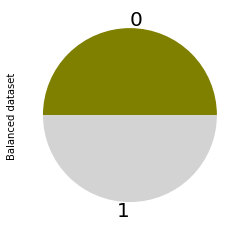

In [5]:
# DISPLAY BALANCED DATASET
train.groupby('label').size().plot(kind='pie',textprops={'fontsize': 20},
                                 colors=['olive','lightgray'],ylabel='Balanced dataset')

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'AskReddit'),
  Text(1, 0, 'politics'),
  Text(2, 0, 'worldnews'),
  Text(3, 0, 'leagueoflegends'),
  Text(4, 0, 'pcmasterrace')])

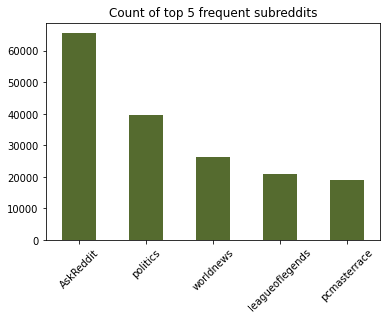

In [6]:
# PLOTTING COUNTS O THE TOP FIVE SUBREDDITS
train['subreddit'].value_counts().head().plot(kind='bar',color='darkolivegreen')
plt.title('Count of top 5 frequent subreddits')
plt.xticks(rotation=45)

In [7]:
from wordcloud import WordCloud, STOPWORDS

In [8]:
wordcloud = WordCloud(background_color='black', stopwords = STOPWORDS,
                max_words = 500, max_font_size = 100, 
                random_state = 17, width=800, height=400)

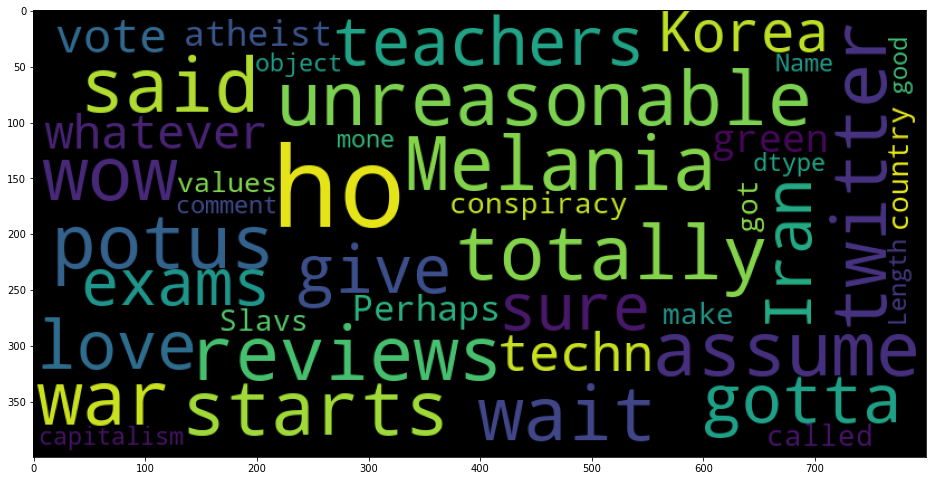

In [9]:
# WORD CLOUD OF SARCASTIC COMMENTS
plt.figure(figsize=(16, 12))
wordcloud.generate(str(train.loc[train['label'] == 1, 'comment']))
plt.imshow(wordcloud)

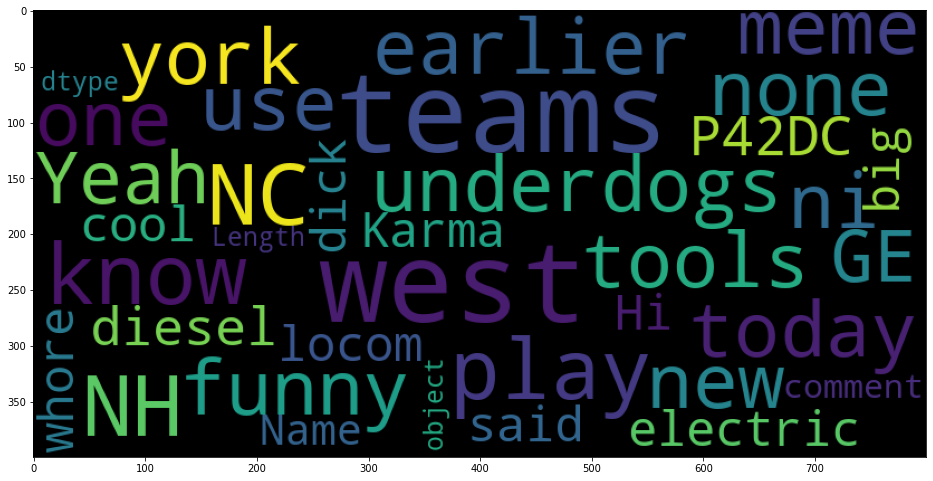

In [10]:
# WORD CLOUD OF SINCERE COMMENTS
plt.figure(figsize=(16, 12))
wordcloud.generate(str(train.loc[train['label'] == 0, 'comment']))
plt.imshow(wordcloud);

# FEATURE ENGINEERING

In [11]:
# DROP ROWS WITH NULL VALUES IN COMMENTS AND RESET THE INDICES
train.dropna(subset=['comment'], inplace = True)
train = train.reset_index(drop=True)

In [12]:
# COUNT NUMBER OF TIMES CAPITAL LETTERS OCCUR IN A STRING
train['count_capital'] = train['comment'].str.count('[A-Z]')

In [13]:
# CONVERT CREATED_UTC TO A DATETIME OBJECT TO EXTRACT YEAR,MONTH,DAY,HOUR,MINUTE AND SECOND VALUES
train['created_utc'] = pd.to_datetime(train['created_utc'])

In [14]:
train['year'] = pd.DatetimeIndex(train['created_utc']).year
train['month'] = pd.DatetimeIndex(train['created_utc']).month
train['day'] = pd.DatetimeIndex(train['created_utc']).day

In [15]:
train['hour'] = pd.DatetimeIndex(train['created_utc']).hour
train['minutes'] = pd.DatetimeIndex(train['created_utc']).minute
train['seconds'] = pd.DatetimeIndex(train['created_utc']).second

In [16]:
# PLOT CORRELATION
corr_df = train.copy()

corr_df['comment']=corr_df['comment'].astype('category').cat.codes
corr_df['author']=corr_df['author'].astype('category').cat.codes
corr_df['subreddit']=corr_df['subreddit'].astype('category').cat.codes
corr_df['parent_comment']=corr_df['parent_comment'].astype('category').cat.codes
corr_df['date']=corr_df['date'].astype('category').cat.codes
corr_df['created_utc']=corr_df['created_utc'].astype('category').cat.codes
corr_df.corr()['label'].abs().sort_values()

author            0.000038
minutes           0.000394
seconds           0.000809
count_capital     0.001004
parent_comment    0.003616
ups               0.006693
score             0.010023
day               0.013389
hour              0.014729
month             0.028446
subreddit         0.046354
comment           0.049173
year              0.052374
downs             0.057533
date              0.057757
created_utc       0.068993
label             1.000000
Name: label, dtype: float64

In [17]:
# DROP COLUMNS WITH WEAK CORRELATION TO THE TARGET
train = train.drop(['score', 'day','hour','date','count_capital',
                    'minutes','seconds','ups','author','parent_comment'], axis =1)

In [18]:
#FINAL DATAFRAME FOR PIPELINE MODELLING
train.head()

label                                            comment  \
0      0                                         NC and NH.   
1      0  You do know west teams play against west teams...   
2      0  They were underdogs earlier today, but since G...   
3      0  This meme isn't funny none of the "new york ni...   
4      0                    I could use one of those tools.   

            subreddit  downs         created_utc  year  month  
0            politics     -1 2016-10-16 23:55:23  2016     10  
1                 nba     -1 2016-11-01 00:24:10  2016     11  
2                 nfl      0 2016-09-22 21:45:37  2016      9  
3  BlackPeopleTwitter     -1 2016-10-18 21:03:47  2016     10  
4  MaddenUltimateTeam     -1 2016-12-30 17:00:13  2016     12

# MODELLING PIPELINES

## LOGISTIC CLASSIFICATION

In [19]:
# CREATING FEATURE MATRIX AND TARGET COLUMN
X = train.iloc[:,1:]
y = train['label']
# SPLITTING TRAIN AND TEST DATA
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=17)

In [20]:
# MAINTAINING AN EXPERIMENT LOG
try:
    expLog
except NameError:
    expLog = pd.DataFrame(columns=["Model Name", 
                                   "Test Accuracy", 
                                  ])

In [21]:
# INTIALIZE MODELS AND TRANSFORMERS
model = LogisticRegression(max_iter=10000,solver='saga')
vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_features=50000,min_df=1)
ohe = OneHotEncoder(handle_unknown='ignore')
std = StandardScaler()

# CONSTRUCT COLUMN TRANSFORMER
column_transformer = ColumnTransformer(
    [('tfidf', vectorizer, 'comment'), 
    ('ohe', ohe,['subreddit','created_utc']),
    ('std',std,['year','downs','month'])
    ])

# CREATE PIPELINE
pipe = Pipeline([('transform', column_transformer),
                  ('lr', model)])
# # FIT PIPELINE
pipe.fit(X_train, y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('tfidf',
                                                  TfidfVectorizer(max_features=50000,
                                                                  ngram_range=(1,
                                                                               2)),
                                                  'comment'),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['subreddit', 'created_utc']),
                                                 ('std', StandardScaler(),
                                                  ['year', 'downs',
                                                   'month'])])),
                ('lr', LogisticRegression(max_iter=10000, solver='saga'))])

In [22]:
# pip install --upgrade scikit-learn

In [23]:
# PRINT PIPELINE STEPS
set_config(display='diagram')
pipe

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('tfidf',
                                                  TfidfVectorizer(max_features=50000,
                                                                  ngram_range=(1,
                                                                               2)),
                                                  'comment'),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['subreddit', 'created_utc']),
                                                 ('std', StandardScaler(),
                                                  ['year', 'downs',
                                                   'month'])])),
                ('lr', LogisticRegression(max_iter=10000, solver='saga'))])

In [24]:
# PRINT TEST ACCURACY
testAcc  = pipe.score(X_test, y_test)
testAcc

0.7280205782691499

In [26]:
# ADD TO THE EXPERIMENT LOG
expLog.loc[len(expLog)] = ['Logistic classification',testAcc]
expLog

Model Name  Test Accuracy
0  Logistic classification       0.728021

## GRADIENT BOOSTING CLASSIFICATION

In [27]:
# INTIALIZE MODELS AND TRANSFORMERS
model = GradientBoostingClassifier()
vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_features=50000,min_df=1)
ohe = OneHotEncoder(handle_unknown='ignore')
std = StandardScaler()

# CONSTRUCT COLUMN TRANSFORMER
column_transformer = ColumnTransformer(
    [('tfidf', vectorizer, 'comment'), 
    ('ohe', ohe,['subreddit','created_utc']),
    ('std',std,['year','downs','month'])
    ])

# CREATE PIPELINE
pipe = Pipeline([('transform', column_transformer),
                  ('clf', model)])

# FIT PIPELINE
pipe.fit(X_train, y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('tfidf',
                                                  TfidfVectorizer(max_features=50000,
                                                                  ngram_range=(1,
                                                                               2)),
                                                  'comment'),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['subreddit', 'created_utc']),
                                                 ('std', StandardScaler(),
                                                  ['year', 'downs',
                                                   'month'])])),
                ('clf', GradientBoostingClassifier())])

In [28]:
# PRINT TEST ACCURACY
testAcc  = pipe.score(X_test, y_test)
testAcc

0.6445549207291434

In [29]:
# ADD TO THE EXPERIMENT LOG
expLog.loc[len(expLog)] = ['Gradient Boosting classification',testAcc]
expLog

Model Name  Test Accuracy
0           Logistic classification       0.728021
1  Gradient Boosting classification       0.644555

## ADAPTIVE BOOSTING CLASSIFICATION

In [30]:
# INTIALIZE MODELS AND TRANSFORMERS
model = AdaBoostClassifier()
vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_features=50000,min_df=1)
ohe = OneHotEncoder(handle_unknown='ignore')
std = StandardScaler()

# CONSTRUCT COLUMN TRANSFORMER
column_transformer = ColumnTransformer(
    [('tfidf', vectorizer, 'comment'), 
    ('ohe', ohe,['subreddit','created_utc']),
    ('std',std,['year','downs','month'])
    ])

# CREATE PIPELINE
pipe = Pipeline([
                  ('transform', column_transformer),
                  ('clf', model)
                ])

# FIT PIPELINE
pipe.fit(X_train, y_train)


Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('tfidf',
                                                  TfidfVectorizer(max_features=50000,
                                                                  ngram_range=(1,
                                                                               2)),
                                                  'comment'),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['subreddit', 'created_utc']),
                                                 ('std', StandardScaler(),
                                                  ['year', 'downs',
                                                   'month'])])),
                ('clf', AdaBoostClassifier())])

In [31]:
# PRINT TEST ACCURACY
testAcc = pipe.score(X_test, y_test)
testAcc

0.6402067720313621

In [32]:
# ADD TO THE EXPERIMENT LOG
expLog.loc[len(expLog)] = ['Adaptive Boosting classification',testAcc]   
expLog

Model Name  Test Accuracy
0           Logistic classification       0.728021
1  Gradient Boosting classification       0.644555
2  Adaptive Boosting classification       0.640207

## BERNOULLI NAIVE BAYES CLASSIFIER

In [34]:
import warnings
warnings.filterwarnings("ignore")

In [35]:
# INTIALIZE MODELS AND TRANSFORMERS
model = model = BernoulliNB()
vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_features=50000,min_df=1)
ohe = OneHotEncoder(handle_unknown='ignore')
std = StandardScaler()

# CONSTRUCT COLUMN TRANSFORMER
column_transformer = ColumnTransformer(
    [('tfidf', vectorizer, 'comment'), 
    ('ohe', ohe,['subreddit','created_utc']),
    ('std',std,['year','downs','month'])
    ])

# CREATE PIPELINE
pipe = Pipeline([('transform', column_transformer),
                  ('clf', model)
                ])

# FIT PIPELINE
# pipe.fit(X_train, y_train)

param_grid_br = {'clf__fit_prior':['True','False'],'clf__alpha':[0,1],'clf__binarize':[0,0.5,1]}
               
gs_br = GridSearchCV(pipe,param_grid_br,cv=5,verbose=1)
gs_br.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transform',
                                        ColumnTransformer(transformers=[('tfidf',
                                                                         TfidfVectorizer(max_features=50000,
                                                                                         ngram_range=(1,
                                                                                                      2)),
                                                                         'comment'),
                                                                        ('ohe',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['subreddit',
                                                                          'created_utc']),
                                                                        ('std',
                                                                         StandardScaler(),
                                                                         ['year',
                                                                          'downs',
                                                                          'month'])])),
                                       ('clf', BernoulliNB())]),
             param_grid={'clf__alpha': [0, 1], 'clf__binarize': [0, 0.5, 1],
                         'clf__fit_prior': ['True', 'False']},
             verbose=1)

In [36]:
gs_br.best_params_

{'clf__alpha': 1, 'clf__binarize': 0, 'clf__fit_prior': 'True'}

In [37]:
testAcc = gs_br.score(X_test,y_test)

In [38]:
# ADD TO THE EXPERIMENT LOG
expLog.loc[len(expLog)] = ['Bernoulli Naive Bayes classification',testAcc]   
expLog

Model Name  Test Accuracy
0               Logistic classification       0.728021
1      Gradient Boosting classification       0.644555
2      Adaptive Boosting classification       0.640207
3  Bernoulli Naive Bayes classification       0.711642